## What does this notebook do?

This notebook compares the original TransPose model with the same model after pruning for 2 iterations
- A chart is made which shows num of weights in the conv layers in original model and pruned models.
- This helps to visualise the size impact of pruning

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os
import pprint

import torch
import torch.nn.parallel
from torch import nn
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms

import tptools._init_paths
from config import cfg
from config import update_config
from core.loss import JointsMSELoss
from core.function import validate
from utils.utils import create_logger

In [2]:
import matplotlib.pyplot as plt

In [3]:
import dataset
import models


In [4]:
import torch.nn.utils.prune as prune

In [5]:
torch.cuda.is_available()

True

In [6]:
def parse_args(args___):
    parser = argparse.ArgumentParser(description='Train keypoints network')
    # general
    parser.add_argument('--cfg',
                        help='experiment configure file name',
                        required=True,
                        type=str)

    parser.add_argument('opts',
                        help="Modify config options using the command-line",
                        default=None,
                        nargs=argparse.REMAINDER)

    parser.add_argument('--modelDir',
                        help='model directory',
                        type=str,
                        default='')
    parser.add_argument('--logDir',
                        help='log directory',
                        type=str,
                        default='')
    parser.add_argument('--dataDir',
                        help='data directory',
                        type=str,
                        default='')
    parser.add_argument('--prevModelDir',
                        help='prev Model directory',
                        type=str,
                        default='')

    args = parser.parse_args(args___)
    return args


In [7]:
config_file_path = 'experiments/coco/transpose_r/TP_R_256x192_d256_h1024_enc4_mh8_chsel.yaml'

In [8]:
# config_file_path = 'experiments/coco/transpose_h/TP_H_w32_256x192_stage3_1_4_d64_h128_relu_enc4_mh1.yaml'

In [9]:
args = parse_args(['--cfg', config_file_path, 'TEST.USE_GT_BBOX', 'True'])

In [10]:
update_config(cfg, args)

In [11]:
cfg

CfgNode({'OUTPUT_DIR': 'output', 'LOG_DIR': 'log', 'DATA_DIR': '', 'GPUS': (0,), 'WORKERS': 1, 'PRINT_FREQ': 100, 'AUTO_RESUME': True, 'PIN_MEMORY': True, 'RANK': 0, 'CUDNN': CfgNode({'BENCHMARK': True, 'DETERMINISTIC': False, 'ENABLED': True}), 'MODEL': CfgNode({'NAME': 'transpose_r_chsel', 'INIT_WEIGHTS': True, 'PRETRAINED': 'models/pytorch/imagenet/resnet50-19c8e357.pth', 'PRETRAINED_CHSEL': 'output/coco/transpose_r_chsel/TP_R_256x192_d256_h1024_enc4_mh8_chsel/pretrained_chsel_1.pth', 'NUM_JOINTS': 17, 'TAG_PER_JOINT': True, 'TARGET_TYPE': 'gaussian', 'IMAGE_SIZE': [192, 256], 'HEATMAP_SIZE': [48, 64], 'SIGMA': 2, 'EXTRA': CfgNode({'FINAL_CONV_KERNEL': 1, 'DECONV_WITH_BIAS': False, 'NUM_DECONV_LAYERS': 1, 'NUM_DECONV_FILTERS': [256], 'NUM_DECONV_KERNELS': [4], 'NUM_LAYERS': 50}), 'NW_CFG': None, 'BOTTLENECK_NUM': 0, 'DIM_MODEL': 256, 'DIM_FEEDFORWARD': 1024, 'ENCODER_LAYERS': 4, 'N_HEAD': 8, 'ATTENTION_ACTIVATION': 'relu', 'POS_EMBEDDING': 'sine', 'INTERMEDIATE_SUP': False, 'PE_ONLY

In [12]:
logger, final_output_dir, tb_log_dir = create_logger(cfg, args.cfg, 'valid')

logger.info(pprint.pformat(args))
logger.info(cfg)

Namespace(cfg='experiments/coco/transpose_r/TP_R_256x192_d256_h1024_enc4_mh8_chsel.yaml', opts=['TEST.USE_GT_BBOX', 'True'], modelDir='', logDir='', dataDir='', prevModelDir='')
AUTO_RESUME: True
CUDNN:
  BENCHMARK: True
  DETERMINISTIC: False
  ENABLED: True
DATASET:
  COLOR_RGB: True
  DATASET: coco
  DATA_FORMAT: jpg
  FLIP: True
  HYBRID_JOINTS_TYPE: 
  NUM_JOINTS_HALF_BODY: 8
  PROB_HALF_BODY: 0.3
  ROOT: data/coco/
  ROT_FACTOR: 45
  SCALE_FACTOR: 0.35
  SELECT_DATA: False
  TEST_SET: val2017
  TRAIN_SET: train2017
DATA_DIR: 
DEBUG:
  DEBUG: False
  SAVE_BATCH_IMAGES_GT: True
  SAVE_BATCH_IMAGES_PRED: True
  SAVE_HEATMAPS_GT: True
  SAVE_HEATMAPS_PRED: True
GPUS: (0,)
LOG_DIR: log
LOSS:
  TOPK: 8
  USE_DIFFERENT_JOINTS_WEIGHT: False
  USE_OHKM: False
  USE_TARGET_WEIGHT: True
MODEL:
  ATTENTION_ACTIVATION: relu
  BOTTLENECK_NUM: 0
  DIM_FEEDFORWARD: 1024
  DIM_MODEL: 256
  ENCODER_LAYERS: 4
  EXTRA:
    DECONV_WITH_BIAS: False
    FINAL_CONV_KERNEL: 1
    NUM_DECONV_FILTERS: [256

=> creating output/coco/transpose_r_chsel/TP_R_256x192_d256_h1024_enc4_mh8_chsel
=> creating log/coco/transpose_r_chsel/TP_R_256x192_d256_h1024_enc4_mh8_chsel_2024-06-12-14-21


In [13]:
cudnn.benchmark = cfg.CUDNN.BENCHMARK
torch.backends.cudnn.deterministic = cfg.CUDNN.DETERMINISTIC
torch.backends.cudnn.enabled = cfg.CUDNN.ENABLED


In [18]:
model = eval('models.'+cfg.MODEL.NAME+'.get_pose_net')(
    cfg, is_train=False
)

==> Add Sine PositionEmbedding~


In [19]:
model.init_weights(cfg.TEST.MODEL_FILE)

=> init final conv weights from normal distribution
=> init .weight as normal(0, 0.001)
=> init .bias as 0
=> loading pretrained model models/pytorch/transpose_coco/tp_r_256x192_enc4_d256_h1024_mh8.pth


:: pos_embedding is loaded from models/pytorch/transpose_coco/tp_r_256x192_enc4_d256_h1024_mh8.pth
:: conv1.weight is loaded from models/pytorch/transpose_coco/tp_r_256x192_enc4_d256_h1024_mh8.pth
:: bn1.weight is loaded from models/pytorch/transpose_coco/tp_r_256x192_enc4_d256_h1024_mh8.pth
:: bn1.bias is loaded from models/pytorch/transpose_coco/tp_r_256x192_enc4_d256_h1024_mh8.pth
:: bn1.running_mean is loaded from models/pytorch/transpose_coco/tp_r_256x192_enc4_d256_h1024_mh8.pth
:: bn1.running_var is loaded from models/pytorch/transpose_coco/tp_r_256x192_enc4_d256_h1024_mh8.pth
:: bn1.num_batches_tracked is loaded from models/pytorch/transpose_coco/tp_r_256x192_enc4_d256_h1024_mh8.pth
:: layer1.0.conv1.weight is loaded from models/pytorch/transpose_coco/tp_r_256x192_enc4_d256_h1024_mh8.pth
:: layer1.0.bn1.weight is loaded from models/pytorch/transpose_coco/tp_r_256x192_enc4_d256_h1024_mh8.pth
:: layer1.0.bn1.bias is loaded from models/pytorch/transpose_coco/tp_r_256x192_enc4_d256_

In [ ]:
model

In [ ]:
# if cfg.TEST.MODEL_FILE:
#     # logger.info('=> loading model from {}'.format(cfg.TEST.MODEL_FILE))
#     print(f"loading model weights from cfg.TEST.MODEL_FILE: {cfg.TEST.MODEL_FILE}")
#     ckpt_state_dict = torch.load(cfg.TEST.MODEL_FILE)
#     # print(ckpt_state_dict['pos_embedding'])  # FOR UNSeen Resolutions
#     # ckpt_state_dict.pop('pos_embedding') # FOR UNSeen Resolutions
#     model.load_state_dict(ckpt_state_dict, strict=True)   #  strict=False FOR UNSeen Resolutions
# else:
#     model_state_file = os.path.join(
#         final_output_dir, 'final_state.pth'
#     )
#     print(f"loading model weights from final_output_dir/final_state.pth: {model_state_file}")
#     # logger.info('=> loading model from {}'.format(model_state_file))
#     model.load_state_dict(torch.load(model_state_file))
# w, h = cfg.MODEL.IMAGE_SIZE

In [21]:
model = torch.nn.DataParallel(model, device_ids=cfg.GPUS).cuda()

# define loss function (criterion) and optimizer
criterion = JointsMSELoss(
    use_target_weight=cfg.LOSS.USE_TARGET_WEIGHT
).cuda()

# Data loading code
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
valid_dataset = eval('dataset.'+cfg.DATASET.DATASET)(
    cfg, cfg.DATASET.ROOT, cfg.DATASET.TEST_SET, False,
    transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=cfg.TEST.BATCH_SIZE_PER_GPU*len(cfg.GPUS),
    shuffle=False,
    num_workers=cfg.WORKERS,
    pin_memory=True
)

loading annotations into memory...


=> classes: ['__background__', 'person']
=> num_images: 5000


Done (t=0.21s)
creating index...
index created!


=> load 6352 samples


In [20]:
nw_cfg_file = os.path.join(final_output_dir, "transpose_r_pruned_iter1_nw_cfg.txt")
with open(nw_cfg_file, "r+") as nw_cfg_fd:
    nw_cfg_str = nw_cfg_fd.read()

In [21]:
import ast
nw_cfg = ast.literal_eval(nw_cfg_str)
nw_cfg

[31, 24, 32, 39, 38, 60, 110, 102, 22, 61, 68, 92, 60, 105]

In [30]:
models_dir = "models/pytorch/"
model_finetune1_path = "transpose_r_modelfile_finetune_iter1.pth"
nw_cfg_1 = [31, 24, 32, 39, 38, 60, 110, 102, 22, 61, 68, 92, 60, 105]
model_finetune2_path = "transpose_r_modelfile_finetune_iter2.pth"
nw_cfg_2 = [30, 17, 24, 28, 35, 57, 99, 86, 14, 46, 55, 78, 53, 90]

In [31]:
pruned_model = eval('models.'+cfg.MODEL.NAME+'.get_pose_net')(
    cfg, is_train=False, nw_cfg = nw_cfg_1
)

==> Add Sine PositionEmbedding~


In [32]:
pruned_model.init_weights(os.path.join(models_dir, model_finetune1_path))

=> init final conv weights from normal distribution
=> init .weight as normal(0, 0.001)
=> init .bias as 0
=> loading pretrained model models/pytorch/transpose_r_modelfile_finetune_iter1.pth


:: pos_embedding is loaded from models/pytorch/transpose_r_modelfile_finetune_iter1.pth
:: conv1.weight is loaded from models/pytorch/transpose_r_modelfile_finetune_iter1.pth
:: bn1.weight is loaded from models/pytorch/transpose_r_modelfile_finetune_iter1.pth
:: bn1.bias is loaded from models/pytorch/transpose_r_modelfile_finetune_iter1.pth
:: bn1.running_mean is loaded from models/pytorch/transpose_r_modelfile_finetune_iter1.pth
:: bn1.running_var is loaded from models/pytorch/transpose_r_modelfile_finetune_iter1.pth
:: bn1.num_batches_tracked is loaded from models/pytorch/transpose_r_modelfile_finetune_iter1.pth
:: layer1.0.conv1.weight is loaded from models/pytorch/transpose_r_modelfile_finetune_iter1.pth
:: layer1.0.bn1.weight is loaded from models/pytorch/transpose_r_modelfile_finetune_iter1.pth
:: layer1.0.bn1.bias is loaded from models/pytorch/transpose_r_modelfile_finetune_iter1.pth
:: layer1.0.bn1.running_mean is loaded from models/pytorch/transpose_r_modelfile_finetune_iter1.

In [46]:
total_orig_conv_wts = 0
total_pruned_conv_wts = 0
orig_modules = list(model.named_modules())
pruned_modules = list(pruned_model.named_modules())
layer_wts_before_prune1 = {}
layer_wts_after_prune1 = {}
for layer_id in range(len(orig_modules)):
    m0 = orig_modules[layer_id]
    m1 = pruned_modules[layer_id]
    # print(layer_id, m0[0], m1[0])
    if isinstance(m0[1], nn.Conv2d):

        orig_conv_wts = m0[1].weight.data.numel()
        total_orig_conv_wts += orig_conv_wts
        pruned_conv_wts = m1[1].weight.data.numel()
        total_pruned_conv_wts += pruned_conv_wts
        print(f"{layer_id}, {m0[0]}, {m1[0]},\t\t\t, {orig_conv_wts}, {pruned_conv_wts}, {pruned_conv_wts/orig_conv_wts}")
        layer_wts_before_prune1[layer_id] = orig_conv_wts
        layer_wts_after_prune1[layer_id] = pruned_conv_wts
        
        
    layer_id += 1
print(total_orig_conv_wts ,total_pruned_conv_wts, total_pruned_conv_wts/total_orig_conv_wts)

1, conv1, conv1,			, 9408, 9408, 1.0
7, layer1.0.conv1, layer1.0.conv1,			, 4096, 4096, 1.0
10, layer1.0.conv2, layer1.0.conv2,			, 36864, 6696, 0.181640625
12, layer1.0.conv3, layer1.0.conv3,			, 16384, 6144, 0.375
16, layer1.0.downsample.0, layer1.0.downsample.0,			, 16384, 16384, 1.0
19, layer1.1.conv1, layer1.1.conv1,			, 16384, 16384, 1.0
22, layer1.1.conv2, layer1.1.conv2,			, 36864, 11232, 0.3046875
24, layer1.1.conv3, layer1.1.conv3,			, 16384, 9984, 0.609375
28, layer1.2.conv1, layer1.2.conv1,			, 16384, 16384, 1.0
31, layer1.2.conv2, layer1.2.conv2,			, 36864, 20520, 0.556640625
33, layer1.2.conv3, layer1.2.conv3,			, 16384, 15360, 0.9375
38, layer2.0.conv1, layer2.0.conv1,			, 32768, 32768, 1.0
41, layer2.0.conv2, layer2.0.conv2,			, 147456, 100980, 0.684814453125
43, layer2.0.conv3, layer2.0.conv3,			, 65536, 52224, 0.796875
47, layer2.0.downsample.0, layer2.0.downsample.0,			, 131072, 131072, 1.0
50, layer2.1.conv1, layer2.1.conv1,			, 65536, 65536, 1.0
53, layer2.1.conv2,

<BarContainer object of 26 artists>

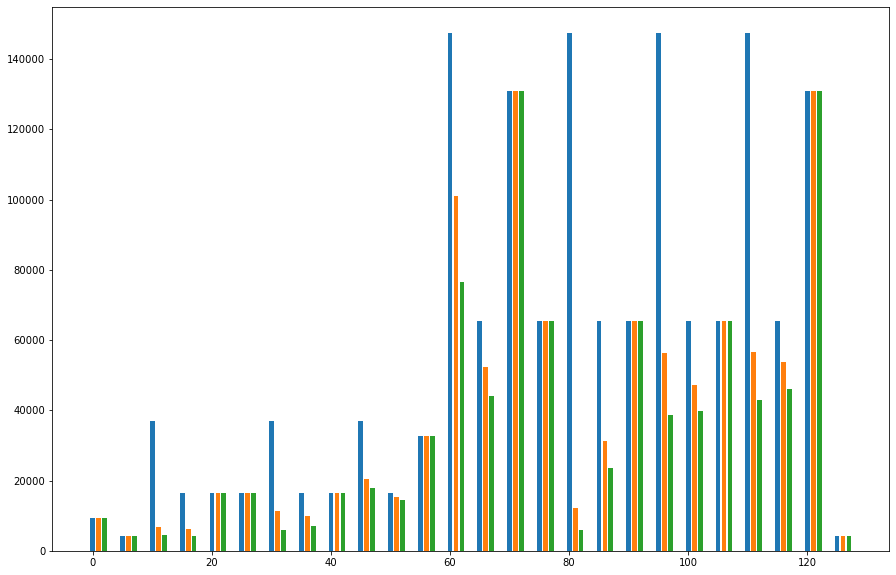

In [51]:
fig, axs = plt.subplots(figsize=(15,10))
plt.bar( range(0,len(layer_wts_before_prune1)*5,5), layer_wts_before_prune1.values())
plt.bar( range(1,len(layer_wts_after_prune1)*5+1,5), layer_wts_after_prune1.values())
plt.bar( range(2,len(layer_wts_after_prune2)*5+2,5), layer_wts_after_prune2.values())

In [41]:
len(orig_modules), len(pruned_modules)

(125, 124)

In [40]:
pruned_model2 = eval('models.'+cfg.MODEL.NAME+'.get_pose_net')(
    cfg, is_train=False, nw_cfg = nw_cfg_2
)
pruned_model2.init_weights(os.path.join(models_dir, model_finetune2_path))

==> Add Sine PositionEmbedding~
=> init final conv weights from normal distribution
=> init .weight as normal(0, 0.001)
=> init .bias as 0
=> loading pretrained model models/pytorch/transpose_r_modelfile_finetune_iter2.pth


:: pos_embedding is loaded from models/pytorch/transpose_r_modelfile_finetune_iter2.pth
:: conv1.weight is loaded from models/pytorch/transpose_r_modelfile_finetune_iter2.pth
:: bn1.weight is loaded from models/pytorch/transpose_r_modelfile_finetune_iter2.pth
:: bn1.bias is loaded from models/pytorch/transpose_r_modelfile_finetune_iter2.pth
:: bn1.running_mean is loaded from models/pytorch/transpose_r_modelfile_finetune_iter2.pth
:: bn1.running_var is loaded from models/pytorch/transpose_r_modelfile_finetune_iter2.pth
:: bn1.num_batches_tracked is loaded from models/pytorch/transpose_r_modelfile_finetune_iter2.pth
:: layer1.0.conv1.weight is loaded from models/pytorch/transpose_r_modelfile_finetune_iter2.pth
:: layer1.0.bn1.weight is loaded from models/pytorch/transpose_r_modelfile_finetune_iter2.pth
:: layer1.0.bn1.bias is loaded from models/pytorch/transpose_r_modelfile_finetune_iter2.pth
:: layer1.0.bn1.running_mean is loaded from models/pytorch/transpose_r_modelfile_finetune_iter2.

In [45]:
total_orig_conv_wts = 0
total_pruned_conv_wts = 0
orig_modules = list(model.named_modules())
pruned_modules = list(pruned_model2.named_modules())

layer_wts_after_prune2 = {}
for layer_id in range(len(orig_modules)):
    m0 = orig_modules[layer_id]
    m1 = pruned_modules[layer_id]
    # print(layer_id, m0[0], m1[0])
    if isinstance(m0[1], nn.Conv2d):

        orig_conv_wts = m0[1].weight.data.numel()
        total_orig_conv_wts += orig_conv_wts
        pruned_conv_wts = m1[1].weight.data.numel()
        total_pruned_conv_wts += pruned_conv_wts
        print(f"{layer_id}, {m0[0]}, {m1[0]},\t\t\t, {orig_conv_wts}, {pruned_conv_wts}, {pruned_conv_wts/orig_conv_wts}")
        # layer_wts_before_prune1[layer_id] = orig_conv_wts
        layer_wts_after_prune2[layer_id] = pruned_conv_wts
        
        
    layer_id += 1
print(total_orig_conv_wts ,total_pruned_conv_wts, total_pruned_conv_wts/total_orig_conv_wts)

1, conv1, conv1,			, 9408, 9408, 1.0
7, layer1.0.conv1, layer1.0.conv1,			, 4096, 4096, 1.0
10, layer1.0.conv2, layer1.0.conv2,			, 36864, 4590, 0.12451171875
12, layer1.0.conv3, layer1.0.conv3,			, 16384, 4352, 0.265625
16, layer1.0.downsample.0, layer1.0.downsample.0,			, 16384, 16384, 1.0
19, layer1.1.conv1, layer1.1.conv1,			, 16384, 16384, 1.0
22, layer1.1.conv2, layer1.1.conv2,			, 36864, 6048, 0.1640625
24, layer1.1.conv3, layer1.1.conv3,			, 16384, 7168, 0.4375
28, layer1.2.conv1, layer1.2.conv1,			, 16384, 16384, 1.0
31, layer1.2.conv2, layer1.2.conv2,			, 36864, 17955, 0.487060546875
33, layer1.2.conv3, layer1.2.conv3,			, 16384, 14592, 0.890625
38, layer2.0.conv1, layer2.0.conv1,			, 32768, 32768, 1.0
41, layer2.0.conv2, layer2.0.conv2,			, 147456, 76626, 0.5196533203125
43, layer2.0.conv3, layer2.0.conv3,			, 65536, 44032, 0.671875
47, layer2.0.downsample.0, layer2.0.downsample.0,			, 131072, 131072, 1.0
50, layer2.1.conv1, layer2.1.conv1,			, 65536, 65536, 1.0
53, layer2.1